In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cPickle, sys, os, gzip
from subprocess import Popen, PIPE
import seaborn as sns
from glob import glob

from scipy.optimize import curve_fit

from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

In [3]:
# This analysis has been ported to the script that parallelizes it
# analysisOutput_MPI.py

In [4]:
import cPickle
if False:
    cPickle.dump(ResultsTot, open("resultsTOT_ALL_DEFINITIVE_clustTriangsNusBetas_" + IDIr.replace("/", "-") + ".pkl", "wb"))
else:
    #ResultsTot = cPickle.load(open("resultsTOT_ALL_DEFINITIVE_clustTriangsNusBetas_-home-ubi-urns-out-.pkl", "rb"))
    ResultsTot = cPickle.load(open("resultsTOT_ALL_MPI_RATge1-home-ubi-urns_serie-out-.pkl", "rb"))
    ResultsTot = cPickle.load(open("resultsTOT_ALL_MPI_FINAL_-home-ubi-urns_serie-out-.pkl", "rb"))

## Aux functions

In [5]:
Nu = lambda r: r/ratio

p_fath = lambda r: 1./3. + .25/Nu(r)

f_fath = lambda r: 3. - 1.75/Nu(r)**.75 # 3. - 2./Nu(r)

nu_tilde = lambda r: 1./ratio

a_fact = lambda r: Nu(r) + 1. - p_fath(r)

b_fact = lambda r: Nu(r) + f_fath(r)# - nu_tilde(r) # CHECK WHY THIS ONE IS MISSING

c_fact = lambda r: 2.*r

Qtilde = lambda r: a_fact(r)/b_fact(r)

Mtilde = lambda r:b_fact(r)/c_fact(r)

AAA = lambda r: 2.*r

BBB = lambda r: 2.*Nu(r) + 2.*r*Mtilde(r) + 1. - f_fath(r) - p_fath(r)

CCC = lambda r: Mtilde(r) * (p_fath(r) - Nu(r) + (Nu(r) + 1. - f_fath(r))*Qtilde(r))

Gamma  = lambda r: (BBB(r) + np.sqrt( (BBB(r)**2.) + 4.*AAA(r)*CCC(r) ))/(4.*r)

Gamma_asympt = lambda r: r/r*Gamma(1000)

# Set once for all the ratios to be analyzed

In [6]:
# Leave empty to do all...
selectedRatios = (.25, .4,  .5,2./3., .75, .8, 1., 5./4., 4./3., 1.5, 1.75, 2., 2.5, 3., 3.5)#, 4.)
selectedRatios = (.4,  .5,2./3., .75, .8, 1., 5./4., 4./3., 1.5, 1.75, 2., 2.5, 3., 3.5)
#selectedRatios = (2.5, 3., 3.5)

In [7]:
sonexch2strat = {
    (0,0): "s=WS",
    (0,1): "s=WSW",
    (0,2): "s=USW",
    (1,0): "s=FS",
    (1,1): "s=ASW",
    (1,2): "s=SSW",
}

## Clustering coefficient $c(t\to\infty)$ case by case

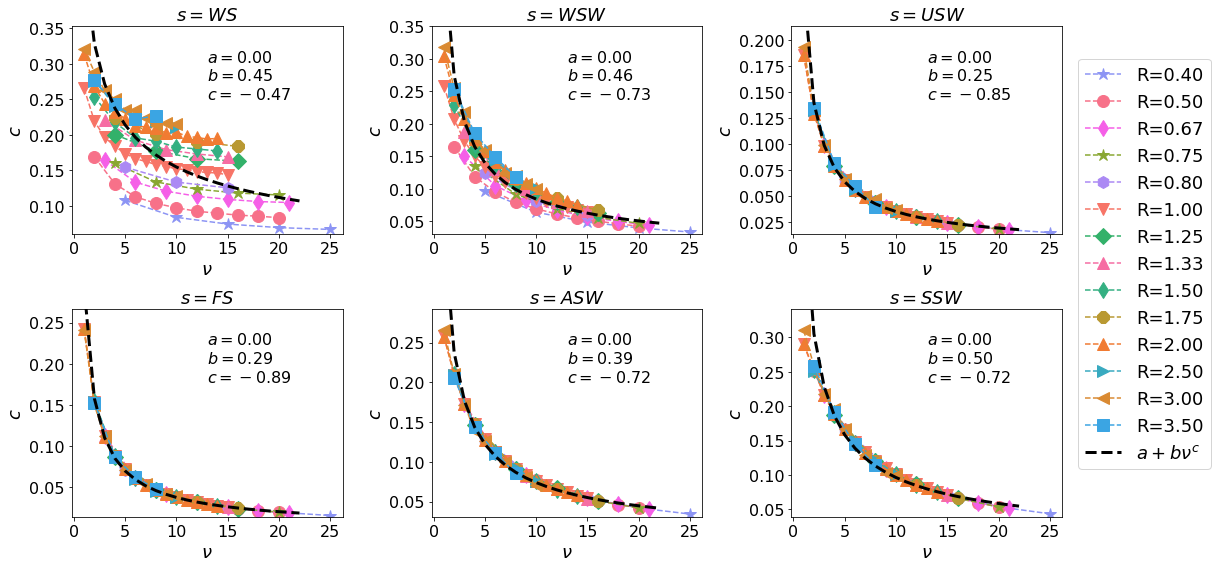

In [24]:
markers="so^*x8pd4"
colors = "rgkcby"

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

nRows, nCols = len(ResultsTot), len(ResultsTot[0])

fig = plt.figure(figsize=(5*nCols,4*nRows))

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}


from scipy.optimize import curve_fit
def generic_fit_foo(x, a, b, c):
    return a + b * x**c

def generic_fit_foo_ln(x, a, b, c):
    return a + b * (x**c)

def pars2string(pars):
    names = ["a", "b", "c"]
    return "\n".join(r"$%s = %.02f$" % (l,k)
                     for l,k in zip(names, pars))

clusteringResults = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        ax = fig.add_subplot(nRows, nCols, sonExch*nCols+sampleStrat+1)
        
        XXXs, YYYs = [], []
        
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
                
            rhos = [k for k in sorted(res.keys())]
            nus = [Nu(r) for r in rhos]
            
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
                
            clustCoeff =np.array([np.sum(np.array(
                                    res[k]['clust_t'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                                  for i,k in enumerate(rhos)])

            XXXs.extend(nus)
            YYYs.extend(clustCoeff)
            
            plt.plot(nus, clustCoeff, linestyle='--', color=colors[ratio], ms=12, label="R=%.02f"%ratio,\
                     marker=markers[ratio])

            tmp_Rho = rhos[-1]
            tmp_Nu = tmp_Rho/ratio

            #prediction = (tmp_Nu - p_to_f[-1]) + (tmp_Nu + 1 - F_const[-1])*A_const[-1]
            #prediction /= 2.*tmp_Rho
            #rhos = np.array(rhos)
            #plt.plot(rhos_theo, Gamma_asympt(rhos_theo), lw=3, linestyle='--', color=colors[ratio])

            
        
        xMAX = 23
        nnn = np.arange(1, xMAX)

        #ax = plt.subplot(nRows,nCols,subplot_index)
        #XXXs = np.array(measuredConstants[sonExch][sampleStrat]["r_gamma"]["x"])
        #YYYs = np.array(measuredConstants[sonExch][sampleStrat]["r_gamma"]["y"])
        res, cov = curve_fit(generic_fit_foo, np.array(XXXs), np.array(YYYs),
                             sigma=np.array(XXXs)**-1.05,
                             p0=[.1, 1., -1.],
                             bounds=((1e-8, 1e-6, -3.), (10., 10., 3.)))
        
        clusteringResults[(sonExch, sampleStrat)] = res
        #f_r_p_params.setdefault(sonExch, {})
        #f_r_p_params[sonExch].setdefault(sampleStrat, {})
        #f_r_p_params[sonExch][sampleStrat]["r"] = res
        
        lines = plt.plot(nnn, generic_fit_foo(nnn, *res), '--k',
                         lw=3, label=r"$a + b \nu^{c}$") # Factor
        #plt.plot(np.arange(xMAX), res[0]*np.ones(xMAX),\
        #    linestyle='-', lw=4, color="k", alpha=.6)
        plt.text(.5, .65, pars2string(res), transform=ax.transAxes, size=16)    
            
            
        plt.xlabel(r"$\nu$", size=18)
        plt.ylabel(r"$c$", size=18)
        plt.xticks(size=16)
        plt.yticks(size=16)

        plt.title(r"$%s$" % sonexch2strat[(sonExch, sampleStrat)], size=18)
        
        #plt.xlim(,31.5)
        plt.ylim(min(YYYs)*.9, max(YYYs)*1.1)
handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
fig.legend(handles, labels, fontsize=18, numpoints=1, loc="upper left", ncol=1, bbox_to_anchor=[.99,.9])
plt.tight_layout()
plt.savefig("fig_clusteringCoefficient_%s.pdf" % file_prefix, bbox_inches='tight')
plt.savefig("fig_clusteringCoefficient_%s.png" % file_prefix, bbox_inches='tight', dpi=300)

# Triangles closure

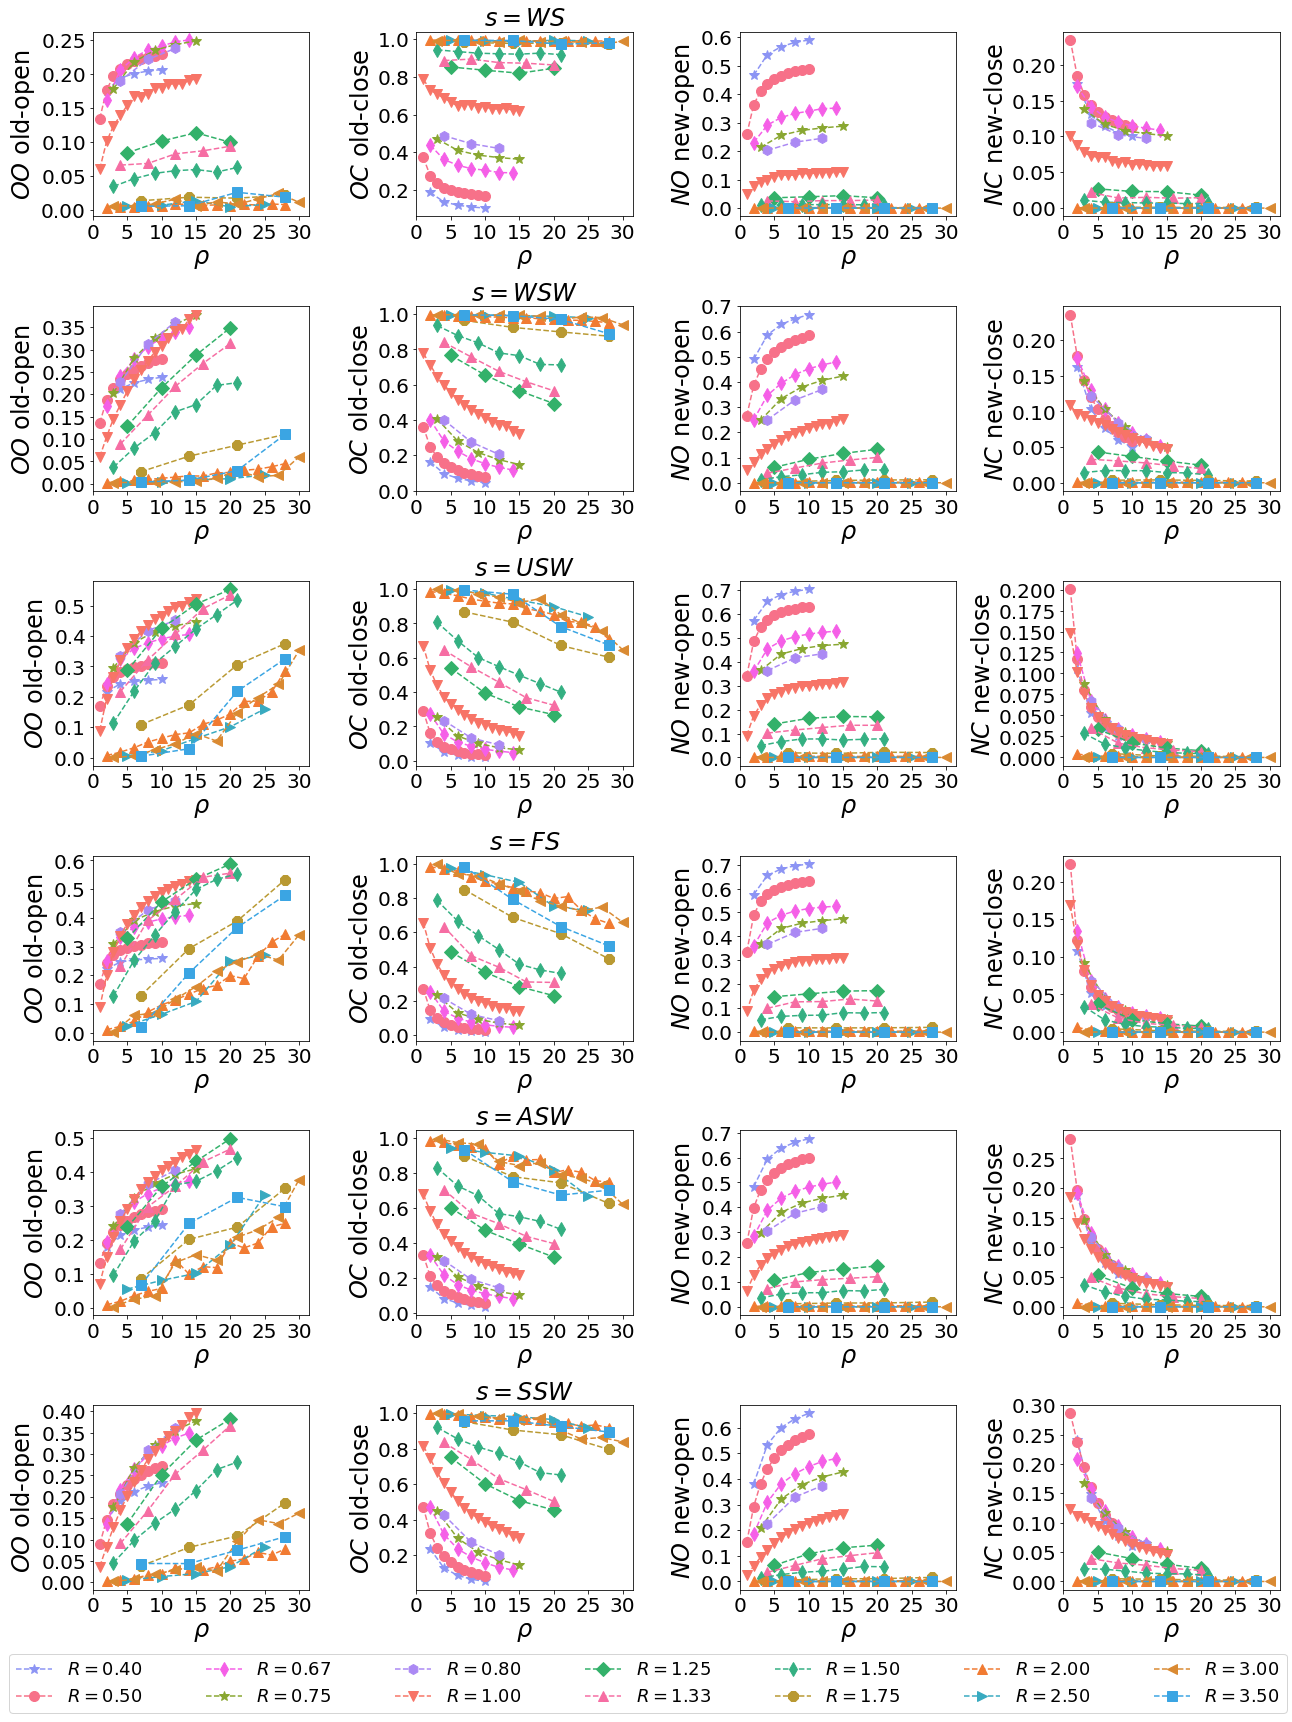

In [64]:
markers="so^*x8pd4"
colors = "rgkcby"

# Indicators to plot
indicatorsToPlot = ["old-open", "old-close", "new-open", "new-close"]
plotyLabels = {"old-open": r"$OO$ old-open", "old-close": r"$OC$ old-close",
               "new-open": r"$NO$ new-open", "new-close": r"$NC$ new-close"}

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

nRows, nCols = 6, len(indicatorsToPlot)
fig = plt.figure(figsize=(4*(nCols+.5), 4*nRows))

measuredConstants = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    measuredConstants[sonExch] = {}
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        measuredConstants[sonExch][sampleStrat] = {k: {"x": [], "y": [], "s": []}
                                                   for k in indicatorsToPlot}
        First=True
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + 1

            rhos = np.array([k for k in sorted(res.keys())])
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
            
            for plot_index, what in enumerate(indicatorsToPlot):
                plt.subplot(nRows, nCols, subplot_index + plot_index)
                if First and float(plot_index + 1)/len(indicatorsToPlot) >= .5:
                    plt.title("$%s$" % sonexch2strat[(sonExch, sampleStrat)], size=24)
                    First = False
                    
                XXXs = rhos
                YYYs = np.array([np.sum(np.array(
                        res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                              for i,k in enumerate(rhos)]
                        )
                measuredConstants[sonExch][sampleStrat][what]["x"].extend(XXXs)
                measuredConstants[sonExch][sampleStrat][what]["y"].extend(YYYs)
                plt.plot(XXXs, YYYs,
                         label=r"$R=%.02f$"%ratio,
                         linestyle='--', color=colors[ratio], ms=10,
                         marker=markers[ratio])

                plt.xlabel(r"$\rho$", size=24)
                plt.ylabel(r"%s" % plotyLabels[what], size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)
                plt.xlim(0,31.5)
                
handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc=3, ncol=len(handles)/2,
           bbox_to_anchor=[0, -.00, 1., -.00], mode="expand")
#plt.legend(fontsize=16, numpoints=1, loc="upper left", ncol=2, bbox_to_anchor=[1,1])
plt.tight_layout(rect=[0, 0.04, 1, 1.])
plt.savefig("fig_trianglesClosure_%s.pdf" % file_prefix, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("fig_trianglesClosure_%s.png" % file_prefix, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

# $F(a) \nu$ and $F(k) \mu$ exponents

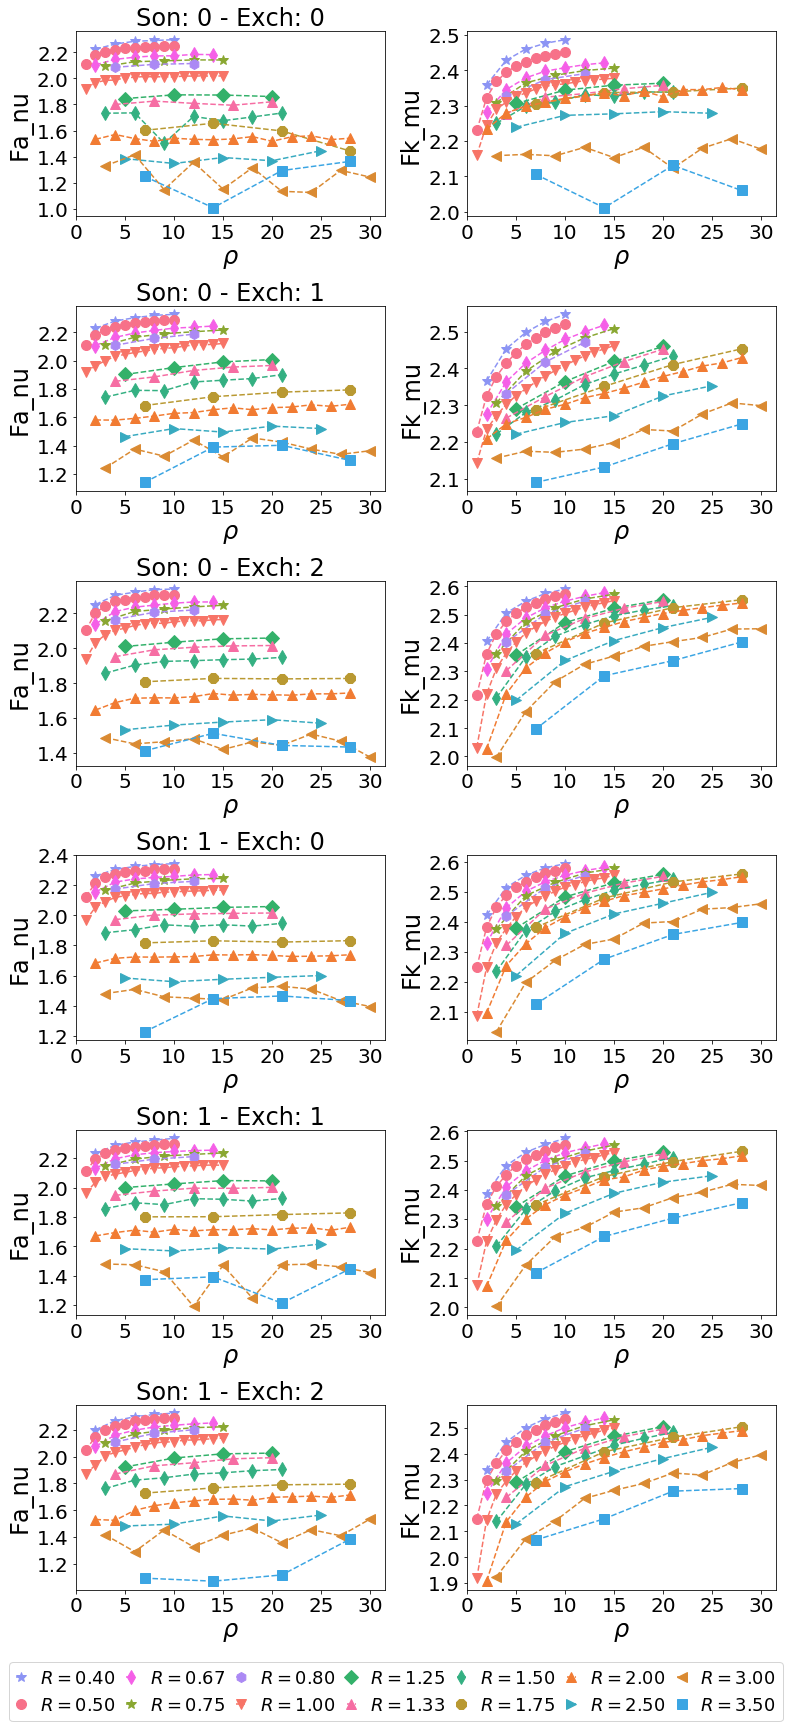

In [10]:
markers="so^*x8pd4"
colors = "rgkcby"

# Indicators to plot
indicatorsToPlot = ["Fa_nu", "Fk_mu"]

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

nRows, nCols = 6, len(indicatorsToPlot)
fig = plt.figure(figsize=(4*(nCols+.75), 4*nRows))

measuredConstants = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    measuredConstants[sonExch] = {}
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        measuredConstants[sonExch][sampleStrat] = {k: {"x": [], "y": [], "s": []}
                                                   for k in indicatorsToPlot}
        First=True
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + 1

            rhos = np.array([k for k in sorted(res.keys())])
            #nnuss = Nu(rhos)
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
            
            for plot_index, what in enumerate(indicatorsToPlot):
                ax = plt.subplot(nRows, nCols, subplot_index + plot_index)
                if First:
                    plt.title("Son: %d - Exch: %d" % (sonExch, sampleStrat), size=24)
                    First = False
                    
                XXXs = rhos
                YYYs = np.array([np.sum(np.array(
                        res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                              for i,k in enumerate(rhos)]
                        )
                measuredConstants[sonExch][sampleStrat][what]["x"].extend(XXXs)
                measuredConstants[sonExch][sampleStrat][what]["y"].extend(YYYs)
                plt.plot(XXXs, YYYs,
                         label=r"$R=%.02f$"%ratio,
                         linestyle='--', color=colors[ratio], ms=10,
                         marker=markers[ratio])

                plt.xlabel(r"$\rho$", size=24)
                plt.ylabel(r"%s" % what, size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)
                plt.xlim(0,31.5)
handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc=3, ncol=len(handles)/2,
           bbox_to_anchor=[0, -.0025, 1., -.0025], mode="expand", handlelength=.5)
plt.tight_layout(rect=[0, 0.04, 1, 1.])
plt.savefig("fig_Fa_Fk_exponents_%s.pdf" % file_prefix, bbox_inches='tight', bbox_extra_artists=(lgd,))

# $\beta$ exponent

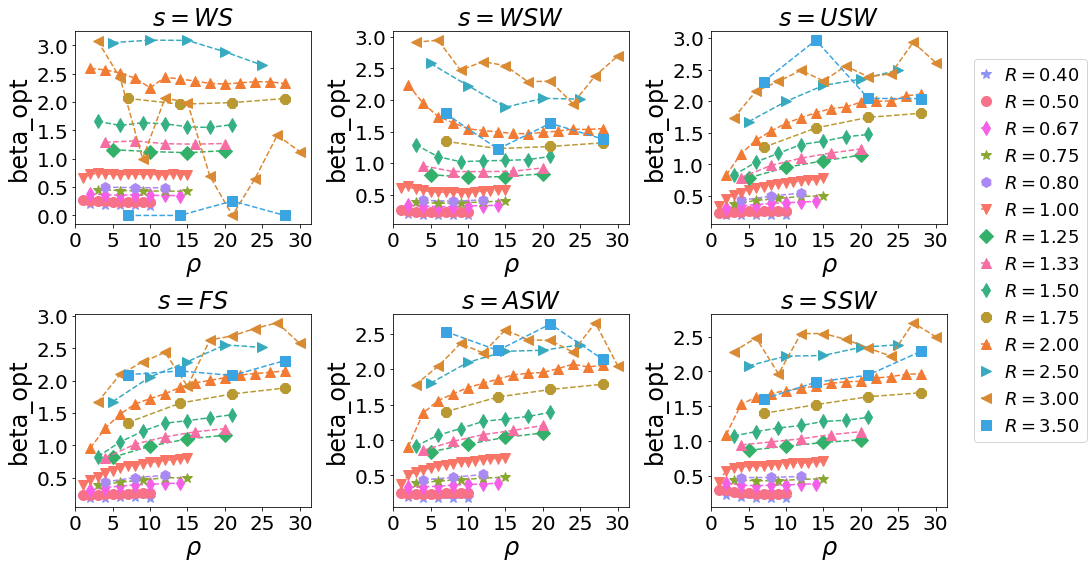

In [20]:
markers="so^*x8pd4"
colors = "rgkcby"

# Indicators to plot
indicatorsToPlot = ["beta_opt"]

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

nRows, nCols = 2, 3 #6, len(indicatorsToPlot)
fig = plt.figure(figsize=(4*(nCols+.35), 4*nRows))

measuredConstants = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    measuredConstants[sonExch] = {}
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        measuredConstants[sonExch][sampleStrat] = {k: {"x": [], "y": [], "s": []}
                                                   for k in indicatorsToPlot}
        First=True
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            subplot_index = (sonExch)*nCols + sampleStrat + 1

            rhos = np.array([k for k in sorted(res.keys())])
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
            
            for plot_index, what in enumerate(indicatorsToPlot):
                ax = plt.subplot(nRows, nCols, subplot_index + plot_index)
                if First:
                    #plt.title("Son: %d - Exch: %d" % (sonExch, sampleStrat), size=24)
                    plt.title("$%s$" % sonexch2strat[(sonExch, sampleStrat)], size=24)
                    First = False
                    
                XXXs = rhos
                YYYs = np.array([np.sum(np.array(
                        res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                              for i,k in enumerate(rhos)]
                        )
                measuredConstants[sonExch][sampleStrat][what]["x"].extend(XXXs)
                measuredConstants[sonExch][sampleStrat][what]["y"].extend(YYYs)
                plt.plot(XXXs, YYYs,
                         label=r"$R=%.02f$"%ratio,
                         linestyle='--', color=colors[ratio], ms=10,
                         marker=markers[ratio])

                plt.xlabel(r"$\rho$", size=24)
                plt.ylabel(r"%s" % what, size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)
                plt.xlim(0,31.5)
                
handles, labels = ax.get_legend_handles_labels()
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc="upper left", ncol=1,
           bbox_to_anchor=[1, .9], handlelength=.5)
#plt.tight_layout(rect=[0, 0.04, 1, 1.])
#plt.savefig("fig_Fa_Fk_exponents_%s.pdf" % file_prefix, bbox_inches='tight', bbox_extra_artists=(lgd,))        

#plt.figlegend(fontsize=16, numpoints=1, loc="upper left", ncol=1, bbox_to_anchor=[1,1])
plt.tight_layout()
plt.savefig("fig_beta_opt_exponents_%s.pdf" % file_prefix, bbox_inches='tight')
plt.savefig("fig_beta_opt_exponents_%s.png" % file_prefix, bbox_inches='tight', dpi=300)

# $\langle k(t)\rangle$'s exponent

In [12]:
from scipy.optimize import curve_fit
def generic_fit_foo(x, a, b, c):
    return a + b * x**c

def generic_fit_foo_ln(x, a, b, c):
    return a + b * (x**c)

def pars2string(pars):
    names = ["a", "b", "c"]
    return "\n".join(r"$%s = %.02f$" % (l,k)
                     for l,k in zip(names, pars))
import pickle
f_r_p_params = pickle.load(open("f_r_params.pkl", "rb"))

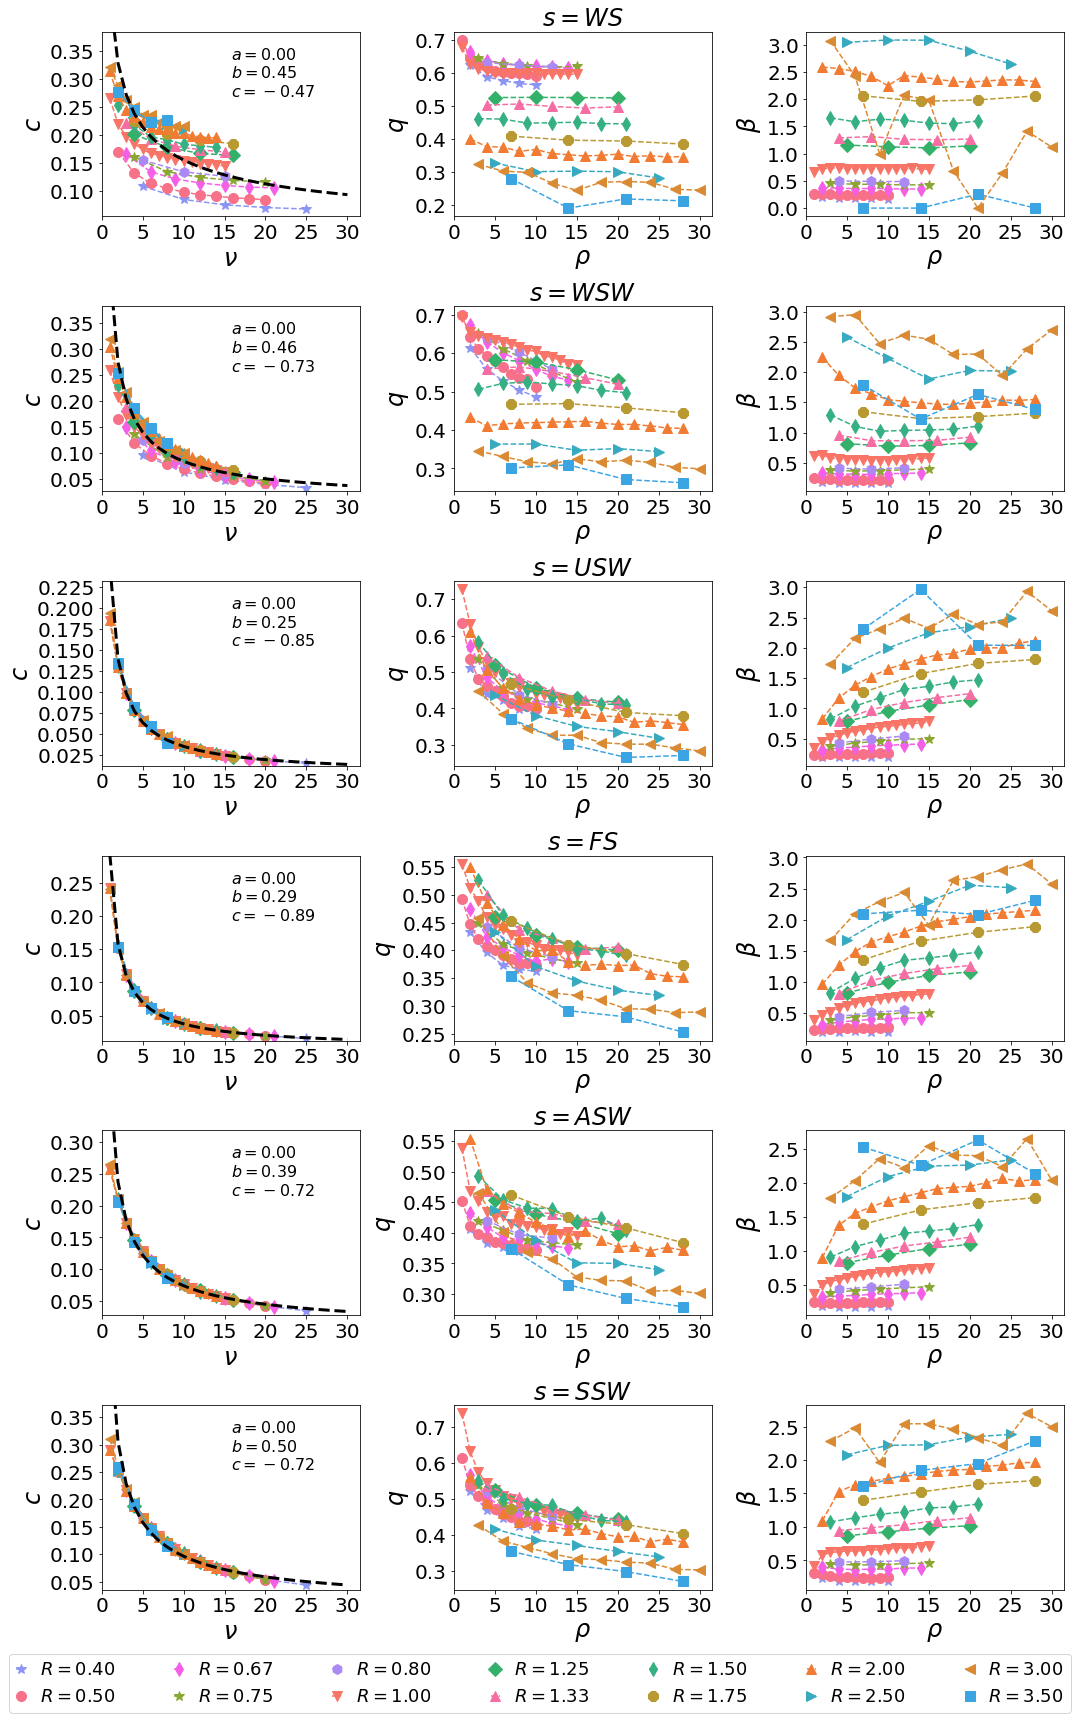

In [61]:
markers="so^*x8pd4"
colors = "rgkcby"

# Indicators to plot
indicatorsToPlot = ["clust_t", "k_a_t", "beta_opt"]
legendDict = {"clust_t": r"$c$", "k_a_t": r"$q$", "beta_opt": r"$\beta$"}


# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False

file_prefix = "ratios_%s_average%d_weighted%d" %\
                    ("%d"%len(selectedRatios) if selectedRatios else "all",
                     plotAverage, averageWeighted)

rhos_theo = np.arange(2, 50)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("husl", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}

nRows, nCols = 6, len(indicatorsToPlot)
fig = plt.figure(figsize=(4*(nCols+.75), 4*nRows))

measuredConstants = {}
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    #if selectedSonSchemes and sonExch not in selectedSonSchemes: continue
    measuredConstants[sonExch] = {}
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        minClust, maxClust = (1, 0)
        
        #if selectedExcSchemes and sampleStrat not in selectedExcSchemes: continue
        measuredConstants[sonExch][sampleStrat] = {k: {"x": [], "y": [], "s": []}
                                                   for k in indicatorsToPlot}
        First=True
        iiiiindex = 0
        for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
            if selectedRatios and ratio not in selectedRatios: continue
            subplot_index = (sonExch*3)*nCols + sampleStrat*nCols + 1

            rhos = np.array([k for k in sorted(res.keys())])
            if plotAverage:
                if averageWeighted:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                else:
                    nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                    weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                positionsIni = np.zeros(len(rhos), dtype=np.int)
                positionsFin = np.array(nTimes, dtype=np.int)
            else:
                nTimes = np.array([1 for _ in rhos])
                weights = [np.ones(1) for _ in nTimes]
                positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                positionsFin = positionsIni + 1
            weightsSum = [np.sum(ws) for ws in weights]
            
            for plot_index, what in enumerate(indicatorsToPlot):
                ax = plt.subplot(nRows, nCols, subplot_index + plot_index)
                if (plot_index+1) / float(len(indicatorsToPlot)) >= .5 and First:
                    #plt.title("Son: %d - Exch: %d" % (sonExch, sampleStrat), size=24)
                    plt.title("$%s$" % sonexch2strat[(sonExch, sampleStrat)], size=24)
                    First = False
                    
                XXXs = rhos
                if what == "k_a_t":
                    YYYs = np.array([np.sum(np.array(
                        [res[k][what][j][-2] for j in range(positionsIni[i], positionsFin[i])])
                            *weights[i])/weightsSum[i]
                                  for i,k in enumerate(rhos)])
                elif what == "clust_t":
                    rhos = [k for k in sorted(res.keys())]
                    nus = [Nu(r) for r in rhos]
            
                    if plotAverage:
                        if averageWeighted:
                            nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                            weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
                        else:
                            nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                            weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
                        positionsIni = np.zeros(len(rhos), dtype=np.int)
                        positionsFin = np.array(nTimes, dtype=np.int)
                    else:
                        nTimes = np.array([1 for _ in rhos])
                        weights = [np.ones(1) for _ in nTimes]
                        positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
                        positionsFin = positionsIni + 1
                    weightsSum = [np.sum(ws) for ws in weights]

                    clustCoeff =np.array([np.sum(np.array(
                                            res[k]['clust_t'][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                                          for i,k in enumerate(rhos)])
                    XXXs = nus
                    YYYs = clustCoeff
                    minClust = min(min(clustCoeff), minClust)
                    maxClust = max(max(clustCoeff), maxClust)
                else:
                    YYYs = np.array([np.sum(np.array(
                        res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                              for i,k in enumerate(rhos)]
                        )
                measuredConstants[sonExch][sampleStrat][what]["x"].extend(XXXs)
                measuredConstants[sonExch][sampleStrat][what]["y"].extend(YYYs)
                #print(what, len(XXXs), len(YYYs), len(weights))
                plt.plot(XXXs, YYYs,
                         label=r"$R=%.02f$"%ratio,
                         linestyle='--', color=colors[ratio], ms=10,
                         marker=markers[ratio])
                
                plt.xlabel(r"$\rho$", size=24)
                if what == "k_a_t" and ratio >= 1.5:
                    Xs = np.copy(XXXs)
                    Xs = Xs[Xs>2]
                    tmp_res = f_r_p_params[sonExch][sampleStrat]["f"]
                    #plt.plot(Xs, (Nu(Xs) + generic_fit_foo(Xs, *tmp_res))/(2.*Xs), "-", color=colors[ratio])
                    
                plt.ylabel(legendDict[what], size=24)
                plt.xticks(size=20)
                plt.yticks(size=20)
                plt.xlim(0,31.5)
                
                if what == "clust_t":
                    ax_clust = ax
        if "clust_t" in indicatorsToPlot:
            ax_clust.set_xlabel(r"$\nu$", size=24)
            xMAX = 31
            nnn = np.arange(1, xMAX)
            resss = clusteringResults[(sonExch, sampleStrat)]
            lines = ax_clust.plot(nnn, generic_fit_foo(nnn, *resss), '--k',
                     lw=3, label=r"$a + b \nu^{c}$") # Factor
            ax_clust.text(.5, .65, pars2string(resss), transform=ax_clust.transAxes, size=16)
            ax_clust.set_ylim(minClust*.8, maxClust*1.2)

plt.xlim(0,31.5)
handles, labels = ax.get_legend_handles_labels()
#plt.subplot(nRows, nCols, nCols)
lgd = plt.figlegend(handles, labels, fontsize=18, numpoints=1, loc=3, ncol=len(handles)/2,
           bbox_to_anchor=[0, -.00, 1., -.00], mode="expand", handlelength=.5)
plt.tight_layout(rect=[0, 0.04, 1, 1.])
plt.savefig("fig_kat-beta_exponents_%s.pdf" % file_prefix, bbox_inches='tight', bbox_extra_artists=(lgd,))
plt.savefig("fig_kat-beta_exponents_%s.png" % file_prefix, bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=300)

## Doing the figures for ratio $R$ / reinforcement $\rho$/ $s$ strategy comparison on the observables

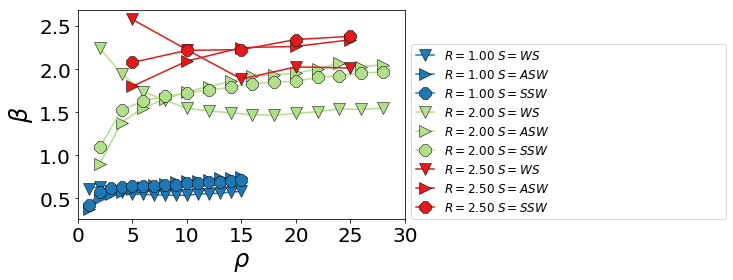

In [14]:
# Beta comparison at different rhos, ratio and strategy...

# The params are (son, exchange, ratio)
selectedParams = [(0,1,1.0), (1,1,1.0), (1,2,1.0),
                  (0,1,2.0), (1,1,2.0), (1,2,2.0),
                  (0,1,2.5), (1,1,2.5), (1,2,2.5),
                 ]
strategyNames = {
    (0,0): "WS",
    (0,1): "WS",
    (0,2): "USW",
    (1,0): "FS",
    (1,1): "ASW",
    (1,2): "SSW",
}

markers="so^*x8pd4"
colors = "rgkcby"

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False
indicatorToPlot = "beta_opt"

file_name = "ratios_Beta_Comparison.pdf"

rhos_theo = np.arange(2, 50)
fig, ax = plt.subplots(1,1)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette(palette="Paired", n_colors=len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
#markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}
for (sonExch, sampleStrat, selRatio) in selectedParams:
    sonResults = ResultsTot[sonExch]
    Results = sonResults[sampleStrat]
    for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
        if ratio != selRatio: continue
        rhos = np.array([k for k in sorted(res.keys())])
        if plotAverage:
            if averageWeighted:
                nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
            else:
                nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
            positionsIni = np.zeros(len(rhos), dtype=np.int)
            positionsFin = np.array(nTimes, dtype=np.int)
        else:
            nTimes = np.array([1 for _ in rhos])
            weights = [np.ones(1) for _ in nTimes]
            positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
            positionsFin = positionsIni + 1
        weightsSum = [np.sum(ws) for ws in weights]
        what = indicatorToPlot
        XXXs = rhos
        YYYs = np.array([np.sum(np.array(
                res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                      for i,k in enumerate(rhos)]
                )
        plt.plot(XXXs, YYYs, linestyle='-', ms=12,
                 label=r"$R=%.02f \; S=%s$"% (ratio, strategyNames[(sonExch, sampleStrat)]),\
                 color=colors[ratio],
                 marker=markers[sonExch*3 + sampleStrat], mew=.5, mec="k")
#                  label=r"$R=%.02f$"%ratio,
#                  linestyle='--', color=colors[ratio], ms=10,
#                  marker=markers[ratio])
        plt.xlabel(r"$\rho$", size=24)
        plt.ylabel(r"$\beta$", size=24)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.xlim(0,30)

handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()
plt.savefig(file_name, bbox_inches='tight')#, bbox_extra_artists=(lgd,))

plt.legend(handles, labels, fontsize=12, numpoints=1, loc=[1.02,0], ncol=1,
           mode="expand", handlelength=1.5)
plt.savefig(file_name.replace(".pdf", "_legend.pdf"), bbox_inches='tight')#, bbox_extra_artists=(lgd,))

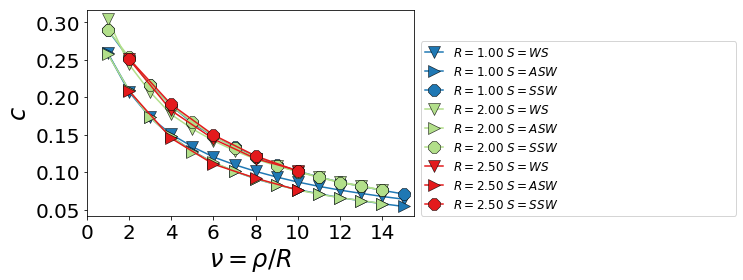

In [15]:
# Beta comparison at different rhos, ratio and strategy...

# The params are (son, exchange, ratio)
selectedParams = [(0,1,1.0), (1,1,1.0), (1,2,1.0),
                  (0,1,2.0), (1,1,2.0), (1,2,2.0),
                  (0,1,2.5), (1,1,2.5), (1,2,2.5),
                 ]
strategyNames = {
    (0,0): "WS",
    (0,1): "WS",
    (0,2): "USW",
    (1,0): "FS",
    (1,1): "ASW",
    (1,2): "SSW",
}

markers="so^*x8pd4"
colors = "rgkcby"

# Plot the average or the longest time?
plotAverage = True
# Weight proportional to elapsed time
averageWeighted = False
indicatorToPlot = "clust_t"

file_name = "ratios_Clust_Comparison.pdf"

rhos_theo = np.arange(2, 50)
fig, ax = plt.subplots(1,1)

allRatios = set()
for sonExch, sonResults in sorted(ResultsTot.iteritems()):
    for sampleStrat, Results in sorted(sonResults.iteritems()):
        allRatios.update(Results.keys())

paletta = sns.color_palette("Paired", len(allRatios))
colors  = [paletta[i] for i in  range(len(allRatios))]
markers = 'ov^<>8sp*hHDd'

colors  = {r: c for r, c in zip(allRatios, colors)}
#markers = {r: markers[i%len(markers)] for i, r in enumerate(allRatios)}
for (sonExch, sampleStrat, selRatio) in selectedParams:
    sonResults = ResultsTot[sonExch]
    Results = sonResults[sampleStrat]
    for curv_n, [ratio, res] in enumerate(sorted(Results.items())):
        if ratio != selRatio: continue
        rhos = np.array([k for k in sorted(res.keys())])
        if plotAverage:
            if averageWeighted:
                nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                weights = [np.array(res[k]['Ev_Steps']) for k in rhos]
            else:
                nTimes = np.array([float(len(res[k]['Ev_Steps'])) for k in rhos])
                weights = [np.ones(len(res[k]['Ev_Steps'])) for k in rhos]
            positionsIni = np.zeros(len(rhos), dtype=np.int)
            positionsFin = np.array(nTimes, dtype=np.int)
        else:
            nTimes = np.array([1 for _ in rhos])
            weights = [np.ones(1) for _ in nTimes]
            positionsIni = np.array([np.argmax(np.array(res[k]['Ev_Steps'])) for k in rhos], dtype=np.int)
            positionsFin = positionsIni + 1
        weightsSum = [np.sum(ws) for ws in weights]
        what = indicatorToPlot
        XXXs = rhos/ratio
        YYYs = np.array([np.sum(np.array(
                res[k][what][positionsIni[i]:positionsFin[i]])*weights[i])/weightsSum[i]
                      for i,k in enumerate(rhos)]
                )
        plt.plot(XXXs, YYYs, linestyle='-', ms=12,
                 label=r"$R=%.02f$ $S=%s$"% (ratio, strategyNames[(sonExch, sampleStrat)]),\
                 color=colors[ratio],
                 marker=markers[sonExch*3 + sampleStrat], mew=.5, mec="k")
#                  label=r"$R=%.02f$"%ratio,
#                  linestyle='--', color=colors[ratio], ms=10,
#                  marker=markers[ratio])
        plt.xlabel(r"$\nu=\rho/R$", size=24)
        plt.ylabel(r"$c$", size=24)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.xlim(0,15.5)

handles, labels = ax.get_legend_handles_labels()
plt.tight_layout()
plt.savefig(file_name, bbox_inches='tight')#, bbox_extra_artists=(lgd,))

plt.legend(handles, labels, fontsize=12, numpoints=1, loc=[1.02,0], ncol=1,
           mode="expand", handlelength=1.5)
plt.savefig(file_name.replace(".pdf", "_legend.pdf"), bbox_inches='tight')#, bbox_extra_artists=(lgd,))

In [14]:
res[k][what]

[0.0, 0.0, 2.5500000000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.72]

In [15]:
np.array([np.sum(np.array(res[k][what][j][-2])*weights[i], axis=0)/weightsSum[i]
                                  for i,k in enumerate(rhos)
                                    for j in range(positionsIni[i], positionsFin[i])]
                            )

IndexError: invalid index to scalar variable.

In [ ]:
fixDict = ResultsTot[1][2][3.][24]
fixTimes = fixDict["Ev_Steps"]
fixArg = np.argmax(np.array(fixTimes) == 10000000)

print fixTimes, fixDict["beta_opt"][fixArg]
if True:
    fixDict["beta_opt"][fixArg] = 2.25
print fixDict["beta_opt"][fixArg]

print fixTimes, fixDict["k_a_t"][fixArg]
if False:
    fixDict["k_a_t"][fixArg] = (fixDict["k_a_t"][fixArg][0]-.015, fixDict["k_a_t"][fixArg][1],
                                fixDict["k_a_t"][fixArg][2] - .015, fixDict["k_a_t"][fixArg][3])
print fixDict["k_a_t"][fixArg]

In [74]:
fixDict = ResultsTot[1][0][3.][18]
fixTimes = fixDict["Ev_Steps"]
fixArg = np.argmax(fixTimes)

print fixTimes, fixDict["k_a_t"][fixArg], fixDict["clust_t"]
if False:
    fixDict["k_a_t"][fixArg] = (fixDict["k_a_t"][fixArg][0]-.07, fixDict["k_a_t"][fixArg][1],
                                fixDict["k_a_t"][fixArg][2], 1e-2)


fixDict = ResultsTot[1][2][.5][3]
fixTimes = fixDict["Ev_Steps"]
fixArg = np.argmax(fixTimes)

#print fixTimes, fixDict["k_a_t"][fixArg]
if False:
    fixDict["k_a_t"][fixArg] = (fixDict["k_a_t"][fixArg][0]-.05, fixDict["k_a_t"][fixArg][1],
                                fixDict["k_a_t"][fixArg][2] - .0406, fixDict["k_a_t"][fixArg][3])

[500000, 1000000, 10000000, 50000000] (array([0.216097  , 0.20235424, 0.19451982, 0.21048833, 0.21909634,
       0.23684214, 0.19969125, 0.2450902 , 0.26571013, 0.24412926,
       0.23709377, 0.23290678, 0.24940677]), array([1.08100726e-01, 9.44651949e-02, 1.40305845e-01, 3.05565585e-02,
       3.86263965e-02, 3.19664127e-02, 3.55970746e-02, 1.01643012e-02,
       2.42319872e-02, 9.24502023e-04, 8.98920465e-04, 1.44831156e-04,
       5.95790683e-05]), 0.2403305913244229, 0.020969786416170075) [0.05722528252354423, 0.06679667758705375, 0.060227692050569166, 0.06298878309455852]


In [75]:
fixDict = ResultsTot[1][0][3.][15]
fixTimes = fixDict["Ev_Steps"]
fixArg = np.argmax(fixTimes)

print fixTimes, fixDict["k_a_t"][fixArg]
if False:
    fixDict["k_a_t"][fixArg] = (fixDict["k_a_t"][fixArg][0]-.07, fixDict["k_a_t"][fixArg][1],
                                fixDict["k_a_t"][fixArg][2], 1e-2)


fixDict = ResultsTot[1][2][.5][3]
fixTimes = fixDict["Ev_Steps"]
fixArg = np.argmax(fixTimes)

print fixTimes, fixDict["k_a_t"][fixArg]
if False:
    fixDict["k_a_t"][fixArg] = (fixDict["k_a_t"][fixArg][0]-.05, fixDict["k_a_t"][fixArg][1],
                                fixDict["k_a_t"][fixArg][2] - .0406, fixDict["k_a_t"][fixArg][3])


[500000, 700000, 1000000, 10000000, 50000000] (array([0.21845678, 0.24256532, 0.21448485, 0.24197818, 0.24942753,
       0.2636824 , 0.27129795, 0.24062151, 0.24096799, 0.26177237,
       0.27685828, 0.27630179, 0.27253337]), array([8.61803230e-02, 3.65220403e-02, 2.98593424e-02, 2.63718776e-02,
       4.01305941e-02, 5.90885843e-02, 1.85119047e-02, 1.25623051e-02,
       6.80176212e-03, 4.76845408e-03, 2.09610032e-04, 1.59092428e-04,
       8.85095716e-05]), 0.270697466716815, 0.02002370261598146)
[100000, 500000] (array([0.46093853, 0.50810489, 0.54063826, 0.55525261]), array([4.56633208e-03, 3.36051266e-04, 3.60944865e-04, 3.90739102e-05]), 0.5296494878397305, 0.03619976117661652)


# Junk

In [4]:
def minDeg(DATA, nodeClass):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    for i in range(binningScheme.index("k")):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return tmpBin["b"][nodeClass[i+1]]

In [6]:
from scipy import optimize

def computeBetaOpt(DATA, Threshold=5, Nmin=5):
    ################################################
    # Threshold: a point must have at least thres-events, thres new events and
    # a difference between the two of at least thres to be accounted for...
    #  Nmin : Minimum number of valid points for a curve to be fitted...
    # Function that returns the mother class(es) to be used for a single pna plot
    currentSuperClass = lambda classID: classID[:1]

    ################################################
    # Beta interval to sweep...
    Beta_int = np.arange(.0, 3.75, .01)

    # Fixed beta overall or use the optimal beta for each bin...
    Fixed_Beta = True

    # setting bounds for c...
    const_bounds = (1e-4, 1e+4)

    
    # Factor smooting the curves...
    smooth_factor = lambda v: (float(max(v))/max(1., min(v)))*.099
    
    binningScheme = DATA["Params"]["binningScheme"]
    pna = DATA['pna']

    # Here we save all the curves for the later fitting procedure and heat-map...
    Pn_Curves = {}

    # We plot the p(n,a)
    lastClass = None
    for nodeClass, pni in sorted(pna.items()):
        valid_degs = [k for k, evs in sorted(pni.items())\
                     if evs['s_new'] >= Threshold and evs['s_eve'] >= Threshold\
                     and (evs['s_eve'] - evs['s_new']) >= Threshold\
                     and float(k) <= minDeg(DATA, nodeClass)]

        X = np.array([float(k) for k in valid_degs])
        Y = np.array([float(pni[k]['s_new'])/float(pni[k]['s_eve']) for k in valid_degs])

        # Cleaning the zeroes...
        X = X[Y>.0]
        Y = Y[Y>.0]

        # Computing the uncertainity on the measured $p(k)$...
        STD_err = np.array([((Y[i]*(1.-Y[i]))/float(pni[k]['s_eve']))**.5\
                            for i,k in enumerate(valid_degs)])

        if len(X) > Nmin:
            X_plot, Y_plot = Smooth_Curve(X, Y, factor=smooth_factor(X))
            Pn_Curves[nodeClass] = {'x': X, 'y': Y, 'w': STD_err, 'x_smooth': X_plot, 'y_smooth': Y_plot}

    # Now we compute the optimal $\beta$, then plotting the fitted $p(k\to k+1)$ with the total rescaled one...

    Tot_Chi_Sums = np.zeros(len(Beta_int), dtype=float)
    opt_pars = {b: {nc: [] for nc, _ in Pn_Curves.items()} for b in Beta_int}
    Chi_Sums = {b: {nc: .0 for nc, _ in Pn_Curves.items()} for b in Beta_int}

    for ii_ind, bb_val in enumerate(Beta_int):
        opt_params = np.array([bb_val, 2.])
        opt_bounds = [(bb_val*.9999, bb_val*1.0001), const_bounds]

        sum_chi_temp, sum_pop_temp, pts_pop_temp = .0, .0, .0
        for nodeClass, classDict in sorted(Pn_Curves.items()):
            nn = classDict['x']
            pn = classDict['y']
            wn = classDict['w']

            par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(p_n_pow_const, x0 = opt_params,\
                    args=(nn, pn, wn), bounds=opt_bounds, approx_grad=True,\
                    maxfun=1000000, maxiter=1000000)

            # Saving the summed chi square...
            sum_chi_temp += chi2_tmp
            sum_pop_temp += DATA['Bins']['N_A_K'][nodeClass]
            pts_pop_temp += float(len(nn) - 1)

            # Saving the constant and the chi_squared...
            opt_pars[bb_val][nodeClass] = [v for v in par_out]
            Chi_Sums[bb_val][nodeClass] = chi2_tmp

        if sum_pop_temp != .0:
            # We normalize by the number of fitted points, indeed this will be
            # the same number for every beta (we always fit the same curves!).
            Tot_Chi_Sums[ii_ind] = sum_chi_temp/pts_pop_temp

    Ind_Bopt = np.argmin(Tot_Chi_Sums)
    Beta_Opt = Beta_int[Ind_Bopt]
    
    return {"pn": Pn_Curves, "Bopt": Beta_Opt, "tot_chi2sums": Tot_Chi_Sums, "opt_pars": opt_pars}

In [7]:
from scipy import optimize

def avgAct(DATA, nodeClass, activityStr="a"):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    i = -1
    for i in range(binningScheme.index(activityStr)):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return sum(tmpBin["b"][nodeClass[i+1]:nodeClass[i+1]+1])/2.

def computeExponentKt(DATA):
    # Select the aggregator of classes...
    currentSuperClass = lambda classID: classID[:1]
    tmpBins = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    selectedSuperClasses = [(i,) for i in range(2, len(tmpBins["b"])-2, 1)]

    activityString = "a" if binningScheme in ("ak", "eak") else "e"

    # Fitting classes to account...
    classFrom, classTo = 0, len(selectedSuperClasses)
    fit_from = 5e+0

    Times = range(0, DATA["Params"]["timeSampled"])     # The indexes of the TVec to be considered...

    kat = DATA['pkt']
    Pakt = DATA['pkt']

    acts = np.array(DATA['Arrays']['Act'])
    max_act = acts.max()
    acts /= max_act
    avg_act = acts.sum()/len(acts)
    Fit_X, Fit_Y = [], []
    for superClass in sorted(selectedSuperClasses):
        if superClass not in selectedSuperClasses[classFrom:classTo]:
            continue
            
        degsFreqs = {}
        validKeys = [nodeClass for nodeClass in sorted(Pakt.keys()) if currentSuperClass(nodeClass) == superClass]
        for nodeClass in validKeys:
            Res = Pakt[nodeClass]
            for time, Values in Res.iteritems():
                if time not in Times:
                    continue
                for tmpDeg, tmpFreq in Values.iteritems():
                    degsFreqs.setdefault(time, {"k": .0, "n": .0})
                    degsFreqs[time]["k"] += tmpDeg*tmpFreq
                    degsFreqs[time]["n"] += tmpFreq        
        if len(degsFreqs) < 2: continue

        # Define something similar to mindeg to compute the avg act...
        act_tmp = avgAct(DATA, nodeClass, activityStr=activityString)
        X = np.array([float(DATA["TimeVecs"]["EventsT"][k]) for k, v in sorted(degsFreqs.items())])
        X *= max_act/X[-1]########

        #Y = np.array([v["k"]/v["n"] for k, v in sorted(degsFreqs.items())])
        Y = np.array([v["k"]/degsFreqs[max(degsFreqs.keys())]["n"] for k, v in sorted(degsFreqs.items())])

        if activityString == "a":
            ####### X *= act_tmp + avg_act
            X *= act_tmp/max_act + avg_act
        elif activityString == "e":
            X /= act_tmp
            
        Fit_X.append(X[X>=fit_from])
        Fit_Y.append(Y[X>=fit_from])

    pars_out = []
    chi2_out = []
    for curveX, curveY in zip(Fit_X, Fit_Y):
        if len(curveX) < 5: continue
        par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., .5, 1e-6],
            args=(curveX, curveY), bounds=[(1e-8, 1e+8), (0.025, 1.025), (.0, 1e-4)],
            approx_grad=True, maxfun=1000000, maxiter=1000000)
        pars_out.append(par_out)
        chi2_out.append(chi2_tmp)
        
    if len(pars_out) > 0:
        best_pars = np.array([p[1] for p in pars_out])
        bestExp = np.average(best_pars,
                              weights=[1./max(1e-3, c) for c in chi2_out])
        bestExpSTD = np.std(best_pars)
    else:
        best_pars = np.array([])
        bestExp = .0
        bestExpSTD = .0
    return (best_pars, np.array(chi2_out), bestExp, bestExpSTD)

In [8]:
IDIr = "/home/ubi/urns/out/"
minimumTime = lambda ratio_val, rho_val: 10000 if ratio_val < 1. else 500000
sonExchSchemes = range(2)
smplStrategies = range(3)

In [7]:
ResultsTot = {}
for sonExch in sonExchSchemes:
    ResultsTot[sonExch] = {}
    for sampleStrat in smplStrategies:
        ResultsTot[sonExch][sampleStrat] = {}
        Results = ResultsTot[sonExch][sampleStrat]
        file_prefix = "Symm_SonsExchg%d_StrctSmpl%d_r" % (sonExch, sampleStrat)
        iii = 0
        dirsToConsider = sorted(os.listdir(IDIr))
        for fname in dirsToConsider:
            iii += 1
            if not (
                fname.startswith(file_prefix)
                and os.path.isdir(os.path.join(IDIr, fname))
                   ):
                continue

            Rho = float(fname.split("_r")[1][:2])
            Nu = float(fname.split("_n")[1][:2])
            Ratio = Rho/Nu
            Evolution_Steps = int(fname.split("_t")[-1].split("_")[0])
            
            if Evolution_Steps < minimumTime(Ratio, Rho):
                continue

            fname = os.path.join(IDIr, fname)
            fname = os.path.join(fname, "data")
            fname = glob(os.path.join(fname, "*_bSchek.dat.gz"))
            if not fname: continue
            fname = fname[0]

            DATA = cPickle.load(gzip.open(fname, "rb"))
            
            timeEvents = np.array(DATA["TimeVecs"]["EventsT"])
            selectedTime = timeEvents
            
            def asymptoticLevel(x, y0):
                return np.ones(len(x))*y0

            Results.setdefault(Ratio, {})
            Results[Ratio].setdefault(Rho, {'clust_t': [], "Fa_nu": [], "Fk_mu": [],
                                            'old-open': [], 'old-close': [],
                                            'new-open': [], 'new-close': [],
                                            'Ev_Steps': [], 'beta_opt': [],
                                            'beta_res': [], 'k_a_t': [],
                                           })
            
            Results[Ratio][Rho]['Ev_Steps'].append(Evolution_Steps)
            
            XXXs, YYYs = timeEvents, DATA["TimeVecs"]["Clust_t"]
            SSSs = 1./(XXXs + 1.)
            p_clust, c_clust = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
            Results[Ratio][Rho]['clust_t'].append(p_clust[0])
            
            totEve_t = np.array(DATA["TimeVecs"]["newCloseTriang"]) + np.array(DATA["TimeVecs"]["newOpenTriang"])+\
                       np.array(DATA["TimeVecs"]["oldOpenTriang"])  + np.array(DATA["TimeVecs"]["oldCloseTriang"])
            for what, label in zip(
                        ["oldOpenTriang", "oldCloseTriang", "newOpenTriang", "newCloseTriang"],
                        ["old-open", "old-close", "new-open", "new-close"]
                    ):
                XXXs, YYYs = selectedTime, np.array(DATA["TimeVecs"][what],dtype=float)/totEve_t
                SSSs = 1./(XXXs + 1.)
                p_res, c_res = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
                Results[Ratio][Rho][label].append(p_res[0])
            
            def powLaw(x, const, esponent):
                return const * x**(-esponent)
            
            f, b = np.histogram(DATA["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
            b = (b[:-1] + b[1:])/2.
            b = b[f>0]
            f = f[f>0]
            
            try:
                res_nu, cov_nu = curve_fit(powLaw, b, f, sigma=1./b**2., maxfev=100000,
                                       p0=[1., -1.], bounds=((1e-8, -3.1), (1e8, 3.1)))
            except RuntimeError:
                print "Nu Fit failed for", fname
                res_nu = [1., 1.]
            Results[Ratio][Rho]['Fa_nu'].append(res_nu[1])
            
            f, b = np.histogram(DATA["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.3), density=True)
            b = (b[:-1] + b[1:])/2.
            b = b[f>0]
            f = f[f>0]
            try:
                res_mu, cov_mu = curve_fit(powLaw, b, f, sigma=1./b**2.,
                                       p0=[1., -1.], bounds=((1e-8, -3.1), (1e8, 3.1)))
            except RuntimeError:
                print "Mu Fit failed for", fname
                res_mu = [1., 1.]
            Results[Ratio][Rho]['Fk_mu'].append(res_mu[1])
            
            # Fit the beta...
            tmp_beta_res = computeBetaOpt(DATA)
            # res = {"pn": Pn_Curves, "Bopt": Beta_Opt, "tot_chi2sums": Tot_Chi_Sums, "opt_pars": opt_pars}
            #Results[Ratio][Rho]['beta_res'].append(tmp_beta_res)
            Results[Ratio][Rho]['beta_opt'].append(tmp_beta_res["Bopt"])
            
            # Fit the <k(a,t)>
            res_kat = computeExponentKt(DATA)
            Results[Ratio][Rho]['k_a_t'].append(res_kat)
            
            del DATA
            sys.stdout.write("\r%03d / %03d" % (iii, len(dirsToConsider)))
            sys.stdout.write(" ratio %d rho %d beta_opt %f" % (Ratio, Rho, tmp_beta_res["Bopt"]))
            sys.stdout.flush()
            
    print "\n", sonExch

KeyboardInterrupt: 

In [8]:
# 2291 / 4270 ratio 1 rho 4 beta_opt 0.580000